In [58]:
%load_ext jupyternotify
import numpy as np
import pandas as pd
import glob
import pickle
from matplotlib import pyplot as plt

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [26]:
# Pickling functions used to save and load the dictionary file

def save_obj(obj, name):
    with open('dataset/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('dataset/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
# Importing UN data
data=[]
name=[]
for file_name in glob.glob('dataset/UNDP_HDI/*.csv'):
    data.append(pd.read_csv(file_name,
                             skiprows=0,
                             na_values="..",
                             na_filter=True,
                             header=1))
    name.append(file_name.split('/')[-1].split('.')[0])

# This snippet is for dealing with the format of the imported dataframes
for i in range(len(data)):
    for col in data[i].columns:
        # Drop columns containing 'Unnamed'
        if "Unnamed" in col: data[i].drop(labels=col, axis=1, inplace=True) 

In [5]:
data_train = pd.read_csv('dataset/train.csv')
columns_train = list(data_train.columns)

In [133]:
# WARNING!------------------------------------------------------------------------
# This code snippet is not to be run if one wants to get a map
# of columns. In that case refer to the *pickled dictionary file* in the dataset
# folder. This is due to the manual corrections present later in this block, which
# are dependant on a certain sequence of columns from UN data, which in turn
# depends on the glob order. This load order might change on your run!

# This code is kept only to record my steps. 

import re

# Function str_comp compares how similar two strings are
# based on matching words or numbers.
# It returns a value from 0 to 1 (if duplicate words present could be more than 1).
# 0 means strings lstr1 and lstr2 contain completely different words
# and the larger the metric — the better similarity. 
# It's very crude, but gets the job done relatively well for my purpose. 

def str_comp(lstr1, lstr2): # lstr1 and lstr2 are strings to be compared
    
    # Forming 2 lists of words from strings, 
    # ignoring all non alphabet/number symbols.
    # filter removes unnecessary blank strings in the list
    # left by re.split.
    l1 = list(filter(None, re.split(r'\W',lstr1)))
    l2 = list(filter(None, re.split(r'\W',lstr2)))
    
    # matchings DO account for duplicate words in one or both lists of strings,
    # in which case it inflates the final metric to more than 1.
    # Ideally it should be fixed, but it works fine for comparing strings. 
    matchings = 0
    for s1 in l1:
        for s2 in l2:
            if s1.lower() == s2.lower(): matchings+=1
    return matchings/max([len(l1), len(l2)])


# Making a list containing indices to match columns between datasets
# based on the str_comp function 'metric'
col_map=[]
for i, col1 in enumerate(name):
    maxim = 0
    j_m = 0
    for j, col2 in enumerate(columns_train):
        comp = str_comp(col1,col2)
        # This part checks whether this combination of list of strings col1 and col2
        # are more similar than the previous best in this loop. It also checks
        # that the second list of strings col2 has not appeared before in
        # col_map to avoid duplicates. 
        if (comp >= maxim) and (j not in [x[1] for x in col_map]): 
            maxim = comp
            j_m = j
    col_map.append((i, j_m))

# Manually fixing mistakes made by the mapping script
# NOTE! This manual corrections may change on different loads of the data
#
# Please, use the columns dict pickle file in the dataset folder 
# for final mapping. 

corrections = {
    (37, 72): (37, 8),
    (43, 78): (43, 72),
    (56, 41): (56, 42),
    (57, 8): (57, 78),
    (10, 42): (10,41),
}

# Final list with corrections:
col_map_corr = [corrections.get(x,x) for x in col_map]

# Now it's nice and dandy
for i, j in col_map_corr:
    print(i, name[i])
    print(j, columns_train[j], '\n')

0 Education Index
9 Education Index 

1 Employment to population ratio (% ages 15 and older)
34 Employment to population ratio (% ages 15 and older) 

2 Population, ages 65 and older (millions)
20 Population, ages 65 and older (millions) 

3 Mortality rate, infant (per 1,000 live births)
17 Mortality rate, infant (per 1,000 live births) 

4 Human Development Index (HDI), female
70 Intergalactic Development Index (IDI), female 

5 Estimated gross national income per capita, female (2011 PPP$)
56 Estimated gross galactic income per capita, female 

6 Share of seats in parliament (% held by women)
47 Share of seats in senate (% held by female) 

7 Labour force participation rate (% ages 15 and older), male
33 Labour force participation rate (% ages 15 and older), male 

8 Remittances, inflows (% of GDP)
62 Remittances, inflows (% of GGP) 

9 International inbound tourists (thousands)
64 Intergalactic inbound tourists (thousands) 

10 Infants lacking immunization, measles (% of one-year-ol


This code was used to save the pickled dict.  
```python
col_map_abs = {}
for i, j in col_map_corr:
    col_map_abs[name[i].strip()] = columns_train[j].strip()

save_obj(col_map_abs, 'column_dict_from_UN_to_Contest_format')
```

In [28]:
col_map_abs=load_obj('column_dict_from_UN_to_Contest_format')

In [29]:
col_map_abs

{'Education Index': 'Education Index',
 'Employment to population ratio (% ages 15 and older)': 'Employment to population ratio (% ages 15 and older)',
 'Population, ages 65 and older (millions)': 'Population, ages 65 and older (millions)',
 'Mortality rate, infant (per 1,000 live births)': 'Mortality rate, infant (per 1,000 live births)',
 'Human Development Index (HDI), female': 'Intergalactic Development Index (IDI), female',
 'Estimated gross national income per capita, female (2011 PPP$)': 'Estimated gross galactic income per capita, female',
 'Share of seats in parliament (% held by women)': 'Share of seats in senate (% held by female)',
 'Labour force participation rate (% ages 15 and older), male': 'Labour force participation rate (% ages 15 and older), male',
 'Remittances, inflows (% of GDP)': 'Remittances, inflows (% of GGP)',
 'International inbound tourists (thousands)': 'Intergalactic inbound tourists (thousands)',
 'Infants lacking immunization, measles (% of one-year-ol

In [6]:
# Forming a complete list of all stripped entries in the Country column

full_list_dirty = set()
for i in range(len(data)):
    countries = [x for x in data[i].loc[:, 'Country'] if str(x) != 'nan']
    countries_stripped = set(map(lambda x: x.strip() , countries))
    full_list_dirty |= countries_stripped

In [7]:
entries_to_remove = set([
    'Arab States',
    'Developing Countries',
    'High human development',
    'Human Development',
    'Least Developed Countries',
    'Low human development',
    'Medium human development',
    'Organization for Economic Co-operation and Development',
    'Small Island Developing States',
    'South Asia',
    'Very high human development',
    'World',
    'East Asia and the Pacific',
    'Latin America and the Caribbean',
    'Regions',
    'Sub-Saharan Africa',
    
])
full_list = full_list_dirty - entries_to_remove
full_list = sorted(list(full_list))

In [323]:
# Index rows of each dataframe in data by Country column
for i in range(len(data)):
    data[i].loc(:, 'Country')
    data[i].set_index('Country', inplace=True)

In [325]:
# Select only rows with countries and columns with years and the country list
for i,df in enumerate(data):
    data[i] = df.iloc[0:189, 1:]

In [583]:
for i in range(len(data)):
    for j, country in enumerate(data[i].loc[:, 'Country']):
        if str(country) != 'nan':
            data[i].loc[j, 'Country'] = country.strip()

In [403]:
i=37
print(name[i])
d = data[i].iloc[0:189, 1:]
d

Human Development Index (HDI)


,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.304,0.312,0.308,0.303,0.327,0.331,0.335,0.339,0.343,0.345,...,0.447,0.464,0.465,0.479,0.485,0.488,0.490,0.491,0.493,0.496
Albania,0.625,0.608,0.611,0.617,0.629,0.639,0.639,0.649,0.660,0.667,...,0.729,0.740,0.759,0.771,0.781,0.787,0.788,0.788,0.789,0.791
Algeria,0.582,0.589,0.593,0.597,0.602,0.610,0.619,0.629,0.638,0.646,...,0.720,0.730,0.738,0.737,0.746,0.749,0.751,0.755,0.758,0.759
Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.759,...,0.830,0.828,0.827,0.849,0.846,0.853,0.850,0.854,0.852,0.857
Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.384,0.394,...,0.508,0.510,0.525,0.537,0.547,0.557,0.565,0.570,0.576,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela (Bolivarian Republic of),0.648,0.654,0.656,0.657,0.660,0.662,0.666,0.668,0.670,0.672,...,0.752,0.753,0.764,0.767,0.772,0.770,0.763,0.752,0.735,0.726
Viet Nam,0.484,0.496,0.506,0.517,0.529,0.540,0.539,0.559,0.566,0.578,...,0.650,0.653,0.663,0.668,0.673,0.675,0.680,0.685,0.690,0.693
Yemen,0.396,0.395,0.398,0.398,0.393,0.408,0.418,0.430,0.423,0.432,...,0.503,0.499,0.511,0.501,0.506,0.504,0.493,0.477,0.463,0.463


In [246]:
cols = [int(x) for x in d.columns[1:]]

In [571]:
idx = pd.IndexSlice

undp_ind = pd.MultiIndex.from_product([cols, full_list], names=['year', 'country'])
undp_data = pd.DataFrame(None, index = undp_ind)

In [591]:
data[0][data[0]['Country'] == 'Afghanistan'].loc[:, '1990']

0    0.122
Name: 1990, dtype: object

In [608]:
np.data[0][data[0]['Country'] == 'a'].loc[:, '1990'].values[0]

numpy.ndarray

In [619]:
# To be commented 

for df, nam in zip(data, name):
    for country in full_list:
        for year in df.columns[2:]:
            val = df[df['Country'] == country].loc[:, year].values
            if len(val) == 0: 
                undp_data.loc[(int(year), country), nam] = np.nan
            else: undp_data.loc[(int(year), country), nam] = val[0]

In [10]:
undp_data.loc[(slice(None),'Albania'),]

NameError: name 'undp_data' is not defined

In [508]:
undp_data.loc[(1990, slice(None)), :].index

MultiIndex([(1990,                         'Afghanistan'),
            (1990,                             'Albania'),
            (1990,                             'Algeria'),
            (1990,                             'Andorra'),
            (1990,                              'Angola'),
            (1990,                 'Antigua and Barbuda'),
            (1990,                           'Argentina'),
            (1990,                             'Armenia'),
            (1990,                           'Australia'),
            (1990,                             'Austria'),
            ...
            (1990,                            ' Vanuatu'),
            (1990, ' Venezuela (Bolivarian Republic of)'),
            (1990,                           ' Viet Nam'),
            (1990,                              ' Yemen'),
            (1990,                             ' Zambia'),
            (1990,                           ' Zimbabwe'),
            (1990,                      

In [30]:
undp_data.loc[(1990, slice(None)), :].index.levels[1]

NameError: name 'undp_data' is not defined

In [443]:
for i,x in enumerate((undp_data.loc[(2000, ' Algeria'), :])):
    if not np.isnan(x): print(i)

44


In [628]:
undp_data.to_csv('dataset/undp_data.csv', na_rep='nan')

In [31]:
#Test data_trainset contains objects only of latest 10 years,
#including unmentioned in train data_train latest year 1016064
unique_years = data_train['galactic year'].unique()
print (unique_years)
print (unique_years.shape)

# print(np.sort(test['galactic year'].unique()))
# print(test['galactic year'].unique().shape)

unique_names = data_train['galaxy'].unique()
unique_names = np.sort(unique_names)
print (unique_names[:5])
print (unique_names.shape)

#Let's map all galactic years to years with increment of 1 year
# and map all galaxies to their unique integer key

#dictionary for replacement of galactic years with normal years
di = {val: ind+1990 for ind, val in enumerate(np.append(unique_years,
                                                     1016064))}
#dictionary for replacement of names with integer keys
di_names = {val: ind+1 for ind, val in enumerate(unique_names)}
data_train.replace({'galactic year':di}, inplace=True)
#test.replace({'galactic year':di}, inplace=True)

# data_train.replace({'galaxy':di_names}, inplace=True)
# test.replace({'galaxy':di_names}, inplace=True)

[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
(26,)
['Andromeda Galaxy (M31)' 'Andromeda I' 'Andromeda II' 'Andromeda III'
 'Andromeda IX']
(181,)


In [32]:
unique_data_years = data_train['galactic year'].unique()
unique_galaxy_names = data_train['galaxy'].unique()

In [33]:
data_train_m = data_train.set_index(['galactic year', 'galaxy'])

In [34]:
# Preparing train set to compare with the UNDP dataset. I dropped some columns since I believe 
# the HDI Ranks for the year from which the original dataset was pulled might
# be different from the one in 2018
data_train_cl = data_train_m.drop(labels=['Intergalactic Development Index (IDI), Rank',
                          'Intergalactic Development Index (IDI), female, Rank',
                          'Intergalactic Development Index (IDI), male, Rank',
                          'y'
                         ],
                  axis = 1)

In [35]:
data_train_cl

existence expectancy index  \
galactic year galaxy                                                     
1990          Large Magellanic Cloud (LMC)                    0.628657   
              Camelopardalis B                                0.818082   
              Virgo I                                         0.659443   
              UGC 8651 (DDO 181)                              0.555862   
              Tucana Dwarf                                    0.991196   
...                                                                ...   
2015          Columba I                                       1.029704   
              Leo II Dwarf (Leo B, DDO 93)                    0.937869   
              Canes Venatici I Dwarf                          1.036144   
              KKs 3                                           0.939034   
              NGC 5237                                        1.032244   

                                            existence expectancy at birth  \
galactic year galaxy                                                        
1990          Large Magellanic Cloud (LMC)                      63.125200   
              Camelopardalis B                                  81.004994   
              Virgo I                                           59.570534   
              UGC 8651 (DDO 181)                                52.333293   
              Tucana Dwarf                                      81.802464   
...                                                                   ...   
2015          Columba I                                         82.832063   
              Leo II Dwarf (Leo B, DDO 93)                      75.877098   
              Canes Venatici I Dwarf                            93.540275   
              KKs 3                                             78.274427   
              NGC 5237                                          91.641356   

                                            Gross income per capita  \
galactic year galaxy                                                  
1990          Large Magellanic Cloud (LMC)             27109.234310   
              Camelopardalis B                         30166.793958   
              Virgo I                                   8441.707353   
              UGC 8651 (DDO 181)                                NaN   
              Tucana Dwarf                             81033.956906   
...                                                             ...   
2015          Columba I                                34310.471408   
              Leo II Dwarf (Leo B, DDO 93)             36899.067719   
              Canes Venatici I Dwarf                   37002.977875   
              KKs 3                                    28180.459770   
              NGC 5237                                 73109.215949   

                                            Income Index  \
galactic year galaxy                                       
1990          Large Magellanic Cloud (LMC)      0.646039   
              Camelopardalis B                  0.852246   
              Virgo I                           0.499762   
              UGC 8651 (DDO 181)                     NaN   
              Tucana Dwarf                      1.131163   
...                                                  ...   
2015          Columba I                         0.855094   
              Leo II Dwarf (Leo B, DDO 93)      0.929494   
              Canes Venatici I Dwarf            1.085245   
              KKs 3                             0.687655   
              NGC 5237                          1.207746   

                                            Expected years of education (galactic years)  \
galactic year galaxy                                                                       
1990          Large Magellanic Cloud (LMC)                                      8.240543   
              Camelopardalis B                                                 10.671823   
      

In [36]:
unique_names.size

181

In [37]:
# Inverse dictionary of col_map_abs: Contest column names -> UNDP column names
col_map_abs_inv = {v: k for k, v in col_map_abs.items()}

In [704]:
undp_order = [col_map_abs_inv.get(x) for x in data_train_cl.columns]

In [707]:
undp_clean = undp_data[undp_order]

In [708]:
undp_clean.to_csv('dataset/undp_clean.csv', na_rep='nan')

In [12]:
# For loading 
undp_clean = pd.read_csv('dataset/undp_clean.csv', na_values='nan').set_index(['year', 'country'])

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_train_scaled = scaler.fit_transform(data_train_cl)
undp_clean_scaled = scaler.fit_transform(undp_clean)

data_train_scaled_sliced = scaler.fit_transform(data_train_cl.loc[(2015, slice(None)),])
undp_clean_scaled_sliced = scaler.fit_transform(undp_clean.loc[(2015, slice(None)),])

In [39]:
from sklearn.metrics.pairwise import pairwise_distances, nan_euclidean_distances

pair_dist = pairwise_distances(data_train_scaled,
                                undp_clean_scaled,
                                metric='nan_euclidean')
pair_dist_slice = pairwise_distances(data_train_scaled_sliced,
                               undp_clean_scaled_sliced,
                               metric='nan_euclidean')

In [40]:
pair_dist_m = np.nan_to_num(pair_dist, nan=np.inf)
pair_dist_slice_m = np.nan_to_num(pair_dist_slice, nan=np.inf)

In [41]:
np.argmin(pair_dist_m, axis = 1)

array([3886, 2671, 3886, ..., 5151,  483, 3911])

In [42]:
print(pair_dist_m.shape)
print(pair_dist_slice_m.shape)

(3865, 5684)
(87, 196)


In [43]:
a = np.argmin(pair_dist_slice_m, axis = 1)
print(a.shape)
a

(87,)


array([107,  36,  84, 109,   8,  34, 170,  86,  82,   2,  30,  73, 139,
       152, 146, 174, 125,  66, 137,  24,  76, 105,  12,  64, 189, 144,
        20, 168,  80,  47,  99,   0,  88,  57, 135,  62, 118, 184,  93,
        13,  22,  28,  90, 122,  69, 115, 149, 161, 154,  26, 181, 141,
        40, 179,  14,  45,  97, 131, 176, 127,  10,  18, 129,  16,  32,
        60, 112, 103,  95, 157, 164, 191,  35, 194, 166,  43,  71, 172,
         6, 120, 159,  38,  50,  52,  55, 133,  31])

In [44]:
data_train_cl.loc[(2015, slice(None)),].index[9]

(2015, 'Tucana III')

In [45]:
undp_clean.loc[(2015, slice(None)),].index[2]

(2015, 'Algeria')

In [49]:
# Compare averages for each galaxy across all years with the same for countries
data_train_aver = []
for galaxy in unique_names:
    data_train_aver.append(data_train_cl.loc[(slice(None), galaxy),].mean(axis = 0).values)

In [50]:
undp_clean_aver = []
for country in full_list:
    undp_clean_aver.append(undp_clean.loc[(slice(None), country),].mean(axis = 0).values)

In [1100]:
#scaler.fit(data_train_aver + undp_clean_aver)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [51]:
np.array(data_train_aver + undp_clean_aver).shape

(377, 74)

In [52]:
pair_dist_aver = pairwise_distances(scaler.fit_transform(data_train_aver),
                                    scaler.fit_transform(undp_clean_aver),
                                    metric='nan_euclidean')

In [53]:
pair_dist_aver.shape

(181, 196)

In [54]:
a = np.argmin(pair_dist_aver, axis=1)
print(len(a))
print(len(set(a)))
print(a)

181
175
[ 90  95  67  76  84  86  98 104  73 107 109  83  71 114  74  79 112 105
  99  96  72  13  96  41 120 117 111  38  62  22  14  17  51 180  55  44
  37  13   7 179  82  66  87  77  56  50  15  39 144  67  27   0 148 154
 167 131 174 188 193 130 189 192  59 191  43 138  40  20 171 126  42 185
  28  26  45   1  46  70 137 178 139 127  34 170 195 155 157 184 134 129
 122 143 140 133 124  88  19  69  57  52  46 125  60  47  97  81 159 158
 160 161  89  35 183  64 172 141 190 128 119 169 166 153 150 186 194  65
 182 132 106  92  53  93 186  79  16  85  29  49  80  94  63  10  33 113
   6  25  31   4  11 118 121  30  23 100   9 103  21   2  18 176 115 145
 142 164 175 136 146 177 173 181 149 168 135 152 163  36   8  24  32  12
 108]


In [55]:
a = np.argmin(pair_dist_aver, axis=1)
print(len(a))
print(len(set(a)))
print(a)

181
175
[ 90  95  67  76  84  86  98 104  73 107 109  83  71 114  74  79 112 105
  99  96  72  13  96  41 120 117 111  38  62  22  14  17  51 180  55  44
  37  13   7 179  82  66  87  77  56  50  15  39 144  67  27   0 148 154
 167 131 174 188 193 130 189 192  59 191  43 138  40  20 171 126  42 185
  28  26  45   1  46  70 137 178 139 127  34 170 195 155 157 184 134 129
 122 143 140 133 124  88  19  69  57  52  46 125  60  47  97  81 159 158
 160 161  89  35 183  64 172 141 190 128 119 169 166 153 150 186 194  65
 182 132 106  92  53  93 186  79  16  85  29  49  80  94  63  10  33 113
   6  25  31   4  11 118 121  30  23 100   9 103  21   2  18 176 115 145
 142 164 175 136 146 177 173 181 149 168 135 152 163  36   8  24  32  12
 108]


In [1128]:
np.min(pair_dist_aver, axis=1)

array([ 1.45108953,  2.61915455,  1.80124229,  1.85009302,  3.68582419,
        3.669292  ,  2.25003874,  3.51710718,  2.20323654,  1.32984736,
        1.84125435,  1.29592784,  2.49506282,  2.23924087,  1.31097102,
        2.62037736,  1.5142816 ,  1.56046141,  5.76352249,  3.16601322,
        1.60263693,  4.77030608,  1.46949284,  1.65363996,  1.81005207,
        2.38325953,  5.95957582,  1.4296124 ,  2.00692248,  1.35184105,
        1.30543542,  2.00697663,  1.72179088,  2.58951793,  1.88753206,
        1.42762494,  1.87330105,  2.19468185,  1.98739725,  1.3006709 ,
        2.26356551,  2.24771742,  1.70825767,  1.54722329,  1.46056319,
        2.44797543,  1.44637693,  2.40729054,  1.38793404,  3.19940706,
        2.51953744,  1.48672796,  1.8826662 ,  1.39966706,  2.27984215,
        1.41118212,  1.68547402,  1.64541788,  2.22169787,  2.51102204,
        1.52607197,  2.05287139,  1.61841482,  1.28392449,  2.89020874,
        1.57849058,  1.25922997,  1.45838409,  2.1405551 ,  1.51

In [75]:
print (unique_names[0])
print (full_list[90])

Andromeda Galaxy (M31)
Kiribati


In [1132]:
data_train_cl.loc[(slice(None), 'Andromeda Galaxy (M31)'),]

,,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),...,Interstellar phone subscriptions (per 100 people),"Interstellar Data Net users, total (% of population)",Current health expenditure (% of GGP),"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII)
galactic year,galaxy,,,,,,,,,,,,,,,,,,,,,
1990,Andromeda Galaxy (M31),0.759989,72.020628,18445.323465,0.647025,13.819287,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.482526,NaN
1991,Andromeda Galaxy (M31),0.769566,68.279470,17844.399709,0.678283,15.518075,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,Andromeda Galaxy (M31),0.791677,69.154885,17407.794954,0.658309,14.660651,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993,Andromeda Galaxy (M31),0.822373,74.018880,27287.948235,0.829902,15.874337,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994,Andromeda Galaxy (M31),0.838323,71.627275,18470.436157,0.578029,14.421358,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995,Andromeda Galaxy (M31),0.816251,71.761981,17164.461458,0.749241,13.770439,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,Andromeda Galaxy (M31),0.841708,72.304760,24638.247525,0.571587,16.341615,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,Andromeda Galaxy (M31),0.732093,72.251446,22284.168313,0.651465,14.308786,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,Andromeda Galaxy (M31),0.836815,69.912499,11289.535180,0.771059,13.390867,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
undp_clean.loc[(slice(None), 'Kiribati'),]

,,Life expectancy Index,Life expectancy at birth,Gross national income (GNI) per capita (2011 PPP$),Income Index,Expected years of schooling (years),Mean years of schooling (years),Human Development Index (HDI),Education Index,Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),...,Mobile phone subscriptions (per 100 people),"Internet users, total (% of population)",Current health expenditure (% of GDP),"Human Development Index (HDI), female","Human Development Index (HDI), male",Gender Development Index (GDI),Adjusted net savings (% of GNI),"HIV prevalence, adult (% ages 15-49), total",Private capital flows (% of GDP),Gender Inequality Index (GII)
year,country,,,,,,,,,,,,,,,,,,,,,
1990,Kiribati,0.610,59.6,2358.0,0.477,10.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.2,NaN
1991,Kiribati,0.616,60.1,3058.0,0.517,10.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,Kiribati,0.622,60.5,3075.0,0.518,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993,Kiribati,0.628,60.8,2930.0,0.510,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994,Kiribati,0.634,61.2,2922.0,0.510,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995,Kiribati,0.639,61.5,3041.0,0.516,10.9,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,Kiribati,0.644,61.9,2620.0,0.493,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,Kiribati,0.649,62.2,3114.0,0.519,10.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,Kiribati,0.654,62.5,3448.0,0.535,10.3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


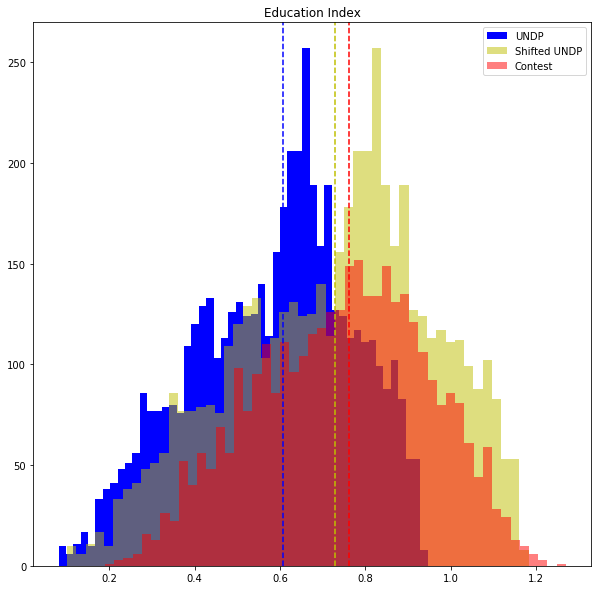

In [85]:
i = 7
plt.figure(figsize=(10,10))
plt.hist(undp_clean.iloc[:, i], color='b', label='UNDP', bins=50)
#plt.hist(undp_clean.iloc[:, i] + 0.2*undp_clean.iloc[:, i].median(), alpha=0.5, color='y', label='Shifted UNDP')
plt.hist(1.25*undp_clean.iloc[:, i], alpha=0.5, color='y', label='Shifted UNDP', bins=50)
plt.hist(data_train_cl.iloc[:, i], color='r', alpha=0.5, label='Contest', bins=50)
plt.axvline(x=undp_clean.iloc[:, i].median(), color='b', ls='--')
plt.axvline(x=data_train_cl.iloc[:, i].median(), color='r', ls='--')
plt.axvline(x=(undp_clean.iloc[:, i] + 0.2*undp_clean.iloc[:, i].median()).median(), color='y', ls='--')

plt.title(undp_clean.columns[i])
plt.legend()
plt.show()

In [1133]:
undp_clean.describe()

,Life expectancy Index,Life expectancy at birth,Gross national income (GNI) per capita (2011 PPP$),Income Index,Expected years of schooling (years),Mean years of schooling (years),Human Development Index (HDI),Education Index,Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),...,Mobile phone subscriptions (per 100 people),"Internet users, total (% of population)",Current health expenditure (% of GDP),"Human Development Index (HDI), female","Human Development Index (HDI), male",Gender Development Index (GDI),Adjusted net savings (% of GNI),"HIV prevalence, adult (% ages 15-49), total",Private capital flows (% of GDP),Gender Inequality Index (GII)
count,5568.000000,5568.000000,5530.000000,5530.000000,5360.000000,5043.000000,4993.000000,4993.000000,3431.000000,3421.000000,...,2093.000000,1947.000000,1688.000000,1915.000000,1914.000000,1913.000000,1632.000000,1644.000000,1822.000000,1792.000000
mean,0.740764,68.148563,15186.824051,0.656812,11.785261,7.472655,0.656677,0.580204,84.176333,71.058170,...,87.943144,38.664201,6.404858,0.663700,0.708495,0.925704,7.227145,1.925304,-4.415587,0.384397
std,0.148879,9.678238,18543.348811,0.182654,3.331989,3.172187,0.165553,0.187169,18.884707,30.351158,...,47.301448,30.322201,2.906059,0.175679,0.150530,0.087908,14.057992,4.355476,25.172391,0.193390
min,0.095000,26.200000,261.000000,0.145000,2.100000,0.300000,0.189000,0.081000,19.000000,3.000000,...,0.000000,0.000000,1.200000,0.081000,0.252000,0.204000,-99.000000,0.100000,-762.000000,0.037000
25%,0.647000,62.075000,2933.750000,0.510250,9.900000,4.800000,0.530000,0.439000,75.000000,46.000000,...,54.000000,9.800000,4.400000,0.531000,0.594000,0.886000,1.800000,0.100000,-5.600000,0.209750
50%,0.778000,70.550000,8123.500000,0.664000,12.100000,7.800000,0.681000,0.608000,93.000000,85.000000,...,95.900000,34.900000,5.900000,0.693000,0.728000,0.955000,8.300000,0.400000,-2.500000,0.398500
75%,0.850000,75.300000,19925.000000,0.800000,14.000000,10.100000,0.787000,0.715000,99.000000,98.000000,...,121.000000,65.150000,8.100000,0.807500,0.822000,0.983000,14.400000,1.500000,-0.200000,0.545000
max,0.995000,84.700000,114214.000000,1.000000,23.300000,14.100000,0.954000,0.946000,100.000000,100.000000,...,259.400000,100.000000,26.300000,0.946000,0.960000,1.052000,49.200000,28.400000,77.100000,0.841000


In [1131]:
undp_clean.loc[(slice(None), 'Kiribati'),]

,,Life expectancy Index,Life expectancy at birth,Gross national income (GNI) per capita (2011 PPP$),Income Index,Expected years of schooling (years),Mean years of schooling (years),Human Development Index (HDI),Education Index,Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),...,Mobile phone subscriptions (per 100 people),"Internet users, total (% of population)",Current health expenditure (% of GDP),"Human Development Index (HDI), female","Human Development Index (HDI), male",Gender Development Index (GDI),Adjusted net savings (% of GNI),"HIV prevalence, adult (% ages 15-49), total",Private capital flows (% of GDP),Gender Inequality Index (GII)
year,country,,,,,,,,,,,,,,,,,,,,,
1990,Kiribati,0.610,59.6,2358.0,0.477,10.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.2,NaN
1991,Kiribati,0.616,60.1,3058.0,0.517,10.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,Kiribati,0.622,60.5,3075.0,0.518,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993,Kiribati,0.628,60.8,2930.0,0.510,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994,Kiribati,0.634,61.2,2922.0,0.510,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995,Kiribati,0.639,61.5,3041.0,0.516,10.9,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,Kiribati,0.644,61.9,2620.0,0.493,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,Kiribati,0.649,62.2,3114.0,0.519,10.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,Kiribati,0.654,62.5,3448.0,0.535,10.3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
